In [24]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from neuron.units import ms, mV
import plotly.io as pio
from matplotlib import pyplot, cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式

from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,color='black',title='', linestyle='-',xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, 
               nonscatter=True, s0=10):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,color=color,linewidth=2,linestyle=linestyle,alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y,linewidth=2,alpha=alpha, linestyle=linestyle,label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
    #     ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=10,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=12,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')

h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
def exp_fitting(x,y, num=1):
    
    if num==2:
        # Calculate integrals
        iy1 = cumtrapz(y, x, initial=0)
        iy2 = cumtrapz(iy1, x, initial=0)


        # Get exponentials lambdas
        Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
        A = pinv(Y) @ y

        lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
        # print("Lambdas:", lambdas)

        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    if num==1:
        iy1 = cumtrapz(y, x, initial=0)

        # Get exponentials lambdas
        Y = np.column_stack((iy1, x, np.ones_like(x)))
        A = pinv(Y) @ y

        lambdas = A[0]
        # print("Lambdas:", lambdas)


        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    return lambdas, P

def time_constant_fitting(run_dt, dtime, fE, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend'):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    # recv = h.Vector()
    # recv.record(L5PC.soma[0](0.5)._ref_v)
    # L5PC.dend[loc].diam = L5PC.dend[58].diam/5.
    # L5PC.dend[loc].gIhbar_Ih = 0.
    # L5PC.dend[0].diam = L5PC.dend[58].diam/4.
    # L5PC.dend[0].diam = 10. 
    # L5PC.dend[loc].diam = L5PC.dend[0].diam*5. 
    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    # for sec in h.allsec():
    #     if h.ismembrane("SKv3_1",sec=sec):
    #         sec.gSKv3_1bar_SKv3_1 = 0.766
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    v_clamp = -77.


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -80 for I input
    else: 
        syn.e = -80.
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur2 = h.tstop
    vclamp.amp2 = v_clamp - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        # vol = h.Vector()
    
        # savdata = open("neuron_voltage.dat", "w")
        T = 200./run_dt+1
        N = int(10./dtime)
        data = np.zeros((2*N, int(T)))


        for i in range(1, N+1):
            vclamp.dur1 = 100. + i * dtime

            ncstim.weight[0] = 0e-2
            go()
            # data[4*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

            
            ncstim.weight[0] = fE
            go()
            # data[4*(i-1)+2,:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector

        # np.savetxt("neuron_voltage.txt", data)
        # print("Done data!")
        I_w_ng = data[::2, :]
        I_w_g = data[1::2, :]
        diff_I = I_w_ng - I_w_g
        x = np.arange(0.1, 10.1, dtime) # ms
        y = -np.sum(diff_I, axis=1)  # size of 100

        result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
        # ground_truth = np.array([-1., -0.2])
        # relative_error = np.abs((result_lambdas - ground_truth)/ground_truth)
        return result_lambdas, y
    
    
    result_lambdas, y = main()
    return result_lambdas, y
    

/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.

In [25]:
L5PC = h.L5PCtemplate(morphologyFilename)

# dendritic EPSP

In [26]:
def shapeplot(var_dend,var_apic,
    figname = 'neurondendriticEPSP_fE1e-3', cmap = cm.jet,
    savefig = False, colorbarlabel='EPSP/mV', ticklabels=False,
    tickmin=0, tickmax=50, dt=10, setv=False, vmin=0., vmax=1.):
    
    # L5PC = h.L5PCtemplate(morphologyFilename)
    for i in range(109):
        L5PC.apic[i].v = var_apic[i]
    
    for i in range(84):
        L5PC.dend[i].v = var_dend[i]
    
    L5PC.soma[0].v=0.
    L5PC.axon[0].v=0.
    L5PC.axon[1].v=0.
 
    v_vals = [seg.v for sec in h.allsec() for seg in sec]
    print(min(v_vals),max(v_vals))
    if setv:
        minv= vmin
        maxv = vmax
    else:
        minv= min(v_vals)
        maxv= max(v_vals)

            
    ps = h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
    ps.variable('v')
    ps.scale(minv, maxv)
    ax = ps.plot(pyplot, cmap=cmap)
    ps.show(1)

    # 设置坐标轴范围
    ax.set_xlim([-700, 0])  # 替换 xmin 和 xmax 为所需的 x 范围
    ax.set_ylim([500, 1400])  # 替换 ymin 和 ymax 为所需的 y 范围
    ax.set_zlim([-1000, 00])  # 替换 zmin 和 zmax 为所需的 z 范围
    # 关闭网格
    ax.grid(False)
    # 关闭坐标轴
    ax.axis('off')
    # 保存为 EPS 格式
    if savefig:
        plt.savefig(figname+'.eps', format='eps')
    
    
    
    # second figure
    ps = h.PlotShape(True)
    ps.variable("v")
    ps.scale(minv, maxv)
    fig = ps.plot(plotly, cmap=cmap)


    # Create a colormap function
    colormap = cm.ScalarMappable(cmap=cmap, 
    norm=mcolors.Normalize(vmin=0, vmax=1)).to_rgba

    # Map the normalized values to a Plotly colorscale as strings
    plotly_colorscale = [[v, f'rgb{tuple(int(255 * c) for c in colormap(v)[:3])}'] for v in np.linspace(0, 1, cmap.N)]

    # Create a separate scatter plot for the colorbar
    colorbar_trace = go.Scatter(
        x=[0],
        y=[0],
        mode='markers',
        marker=dict(
            colorscale=plotly_colorscale,
            cmin=minv,
            cmax=maxv,
            colorbar=dict(
                title=colorbarlabel,
                thickness=20  # Adjust the thickness of the colorbar
            ),
            showscale=True
        )
    )

    # Add the colorbar trace to the figure
    fig.add_trace(colorbar_trace)
    fig.update_xaxes(showticklabels=False, showgrid=True)
    fig.update_yaxes(showticklabels=False, showgrid=True)
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.show()
    if savefig:
        # 保存动图为 HTML 文件
        plotly.offline.plot(fig, filename=figname+'.html', auto_open=False)
    

    # 创建自定义的颜色映射
    cmap = cmap
    colormap = cm.ScalarMappable(cmap=cmap, 
            norm=mcolors.Normalize(vmin=minv, vmax=maxv))

    # 创建一个新的图形和轴
    fig, ax = plt.subplots(figsize=(6, 1))

    # 绘制颜色条
    cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
    cbar.set_label(colorbarlabel)
    if ticklabels:
        cbar.set_ticks(np.arange(tickmin, tickmax, dt))
        cbar.set_ticklabels([f'{i}' for i in np.arange(tickmin, tickmax, dt)])

    # 设置图的边界
    plt.tight_layout()

    if savefig:
        # 保存为 EPS 格式
        plt.savefig(figname+'colorbar'+'.eps', format='eps')

    # 显示图形（可选）
    plt.show()
    
    print(minv,maxv)

    

In [92]:
estimated_lambdas_apic = np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
estimated_lambdas_apic_rise = -1./estimated_lambdas_apic[:,0]
estimated_lambdas_apic_decay = -1./estimated_lambdas_apic[:,1]
 
estimated_lambdas_dend = np.loadtxt("estimated_lambdas_passive_dendloc84.txt")
estimated_lambdas_dend_rise = -1./estimated_lambdas_dend[:,0]
estimated_lambdas_dend_decay = -1./estimated_lambdas_dend[:,1]
var_dend = estimated_lambdas_dend_decay
var_apic = estimated_lambdas_apic_decay

savefig=True
figname='active_decay_fE1e3'
cmap=cm.jet
L5PC = h.L5PCtemplate(morphologyFilename)
for i in range(109):
    L5PC.apic[i].v = var_apic[i]

for i in range(84):
    L5PC.dend[i].v = var_dend[i]

L5PC.soma[0].v=0.
L5PC.axon[0].v=0.
L5PC.axon[1].v=0.

v_vals = [seg.v for sec in h.allsec() for seg in sec]

    
ps = h.PlotShape(True)
ps.variable("v")
ps.scale(min(v_vals), max(v_vals))
fig = ps.plot(plotly, cmap=cmap)

v_vals = [seg.v for sec in h.allsec() for seg in sec]
# Create a custom colormap using Matplotlib (cool colormap)
cmap = cmap

# Create a colormap function
colormap = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1)).to_rgba

# Map the normalized values to a Plotly colorscale as strings
plotly_colorscale = [[v, f'rgb{tuple(int(255 * c) for c in colormap(v)[:3])}'] for v in np.linspace(0, 1, cmap.N)]

# Create a separate scatter plot for the colorbar
colorbar_trace = go.Scatter(
    x=[0],
    y=[0],
    mode='markers',
    marker=dict(
        colorscale=plotly_colorscale,
        cmin=min(v_vals),
        cmax=max(v_vals),
        colorbar=dict(
            title='',
            thickness=20  # Adjust the thickness of the colorbar
        ),
        showscale=True
    )
)

# Add the colorbar trace to the figure
fig.add_trace(colorbar_trace)
fig.update_xaxes(showticklabels=False, showgrid=True)
fig.update_yaxes(showticklabels=False, showgrid=True)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

# 保存动图为 HTML 文件
plotly.offline.plot(fig, filename=figname+'.html', auto_open=False)


'active_decay_fE1e3.html'

In [15]:
EPSP_den = np.loadtxt('EPSP_passive_dend84.txt')
EPSP_den_syn = EPSP_den[:,1]
EPSP_den_soma = EPSP_den[:,0]
EPSP_apic = np.loadtxt('EPSP_passive_apicloc109.txt')
EPSP_apic_syn = EPSP_apic[:,1]
EPSP_apic_soma = EPSP_apic[:,0]
var_dend=EPSP_den_syn
var_apic=EPSP_apic_syn
L5PC = h.L5PCtemplate(morphologyFilename)
for i in range(109):
    L5PC.apic[i].v = var_apic[i]

for i in range(84):
    L5PC.dend[i].v = var_dend[i]

L5PC.soma[0].v=0.
L5PC.axon[0].v=0.
L5PC.axon[1].v=0.

v_vals = [seg.v for sec in h.allsec() for seg in sec]
print(min(v_vals),max(v_vals))

0.0 58.97621760063053


2.1946777453085673 56.648052586738594
2.0488825131683086 58.97621760063053
0.0 58.97621760063053


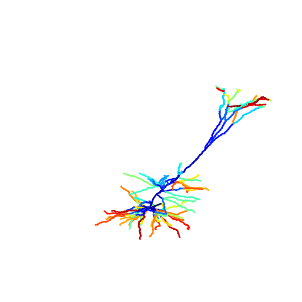

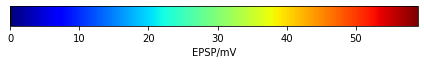

0.0 58.97621760063053


In [18]:
EPSP_den = np.loadtxt('EPSP_passive_dend84.txt')
EPSP_den_syn = EPSP_den[:,1]
EPSP_den_soma = EPSP_den[:,0]
EPSP_apic = np.loadtxt('EPSP_passive_apicloc109.txt')
EPSP_apic_syn = EPSP_apic[:,1]
EPSP_apic_soma = EPSP_apic[:,0]
var_dend=EPSP_den_syn
var_apic=EPSP_apic_syn
print(np.min(var_dend),np.max(var_dend))
print(np.min(var_apic),np.max(var_apic))
shapeplot(var_dend, var_apic, 
        figname = 'active_fE1e4_EPSP_dend', 
        savefig = False, colorbarlabel='EPSP/mV',ticklabels=False,
        tickmin=0, tickmax=13, dt=4., cmap=cm.jet)

# time constant estimation

1.0025045051652444 5.000471226641927
1.0022196118103752 4.3461750504288466


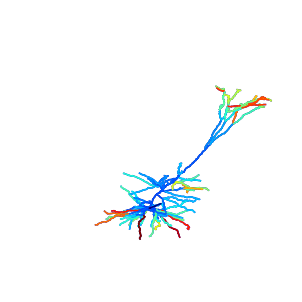

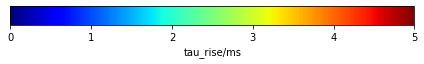

0.0 5.000471226641927


In [15]:
estimated_lambdas_apic = np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
estimated_lambdas_apic_rise = -1./estimated_lambdas_apic[:,0]
estimated_lambdas_apic_decay = -1./estimated_lambdas_apic[:,1]
 
estimated_lambdas_dend = np.loadtxt("estimated_lambdas_passive_dendloc84.txt")
estimated_lambdas_dend_rise = -1./estimated_lambdas_dend[:,0]
estimated_lambdas_dend_decay = -1./estimated_lambdas_dend[:,1]
var_dend = estimated_lambdas_dend_rise
var_apic = estimated_lambdas_apic_rise
print(np.min(var_dend),np.max(var_dend))
print(np.min(var_apic),np.max(var_apic))
shapeplot(var_dend, var_apic, 
        figname = 'active_decay_fE1e3', 
        savefig = False, colorbarlabel='tau_rise/ms',ticklabels=False,
        tickmin=0, tickmax=3, dt=1, cmap=cm.jet)

# error

0.00022792753277851575 0.03889481434483653
4.040897913348829e-05 0.025594744001283764
0.0 0.03889481434483653


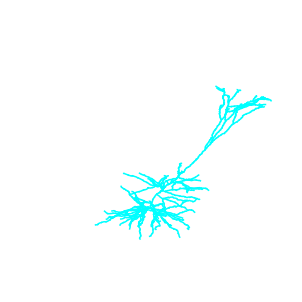

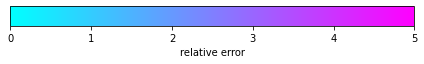

0.0 5.0


In [28]:
estimated_lambdas_apic = np.loadtxt("estimated_lambdas_passive_apicloc109_fE1e4.txt")
estimated_lambdas_apic_rise_error = np.abs(-1./estimated_lambdas_apic[:,0]-1.0)
estimated_lambdas_apic_decay_error = np.abs(-1./estimated_lambdas_apic[:,1] - 5.0)/5.
 
estimated_lambdas_dend = np.loadtxt("estimated_lambdas_passive_dendloc84_fE1e4.txt")
estimated_lambdas_dend_rise_error = np.abs(-1./estimated_lambdas_dend[:,0] - 1.0)
estimated_lambdas_dend_decay_error = np.abs(-1./estimated_lambdas_dend[:,1] - 5.0)/5.
var_dend = estimated_lambdas_dend_decay_error
var_apic = estimated_lambdas_apic_decay_error
print(np.min(var_dend),np.max(var_dend))
print(np.min(var_apic),np.max(var_apic))
shapeplot(var_dend, var_apic, 
        figname = 'active_decay_fE1e3', 
        savefig = False, colorbarlabel='relative error',ticklabels=False,
        tickmin=0, tickmax=3, dt=1, cmap=cm.cool, setv=True, vmin=0., vmax=5.)

0.0 0.2501113072266339


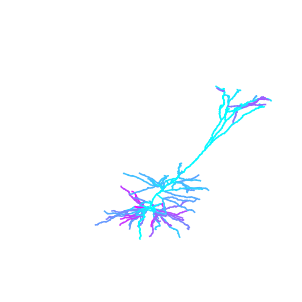

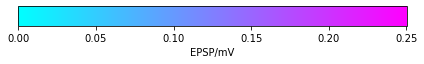

0.0 0.2501113072266339


In [18]:
estimated_lambdas_apic = np.loadtxt("estimated_lambdas_passive_apicloc109.txt")
estimated_lambdas_apic_rise_error = np.abs(-1./estimated_lambdas_apic[:,0]-1.0)
estimated_lambdas_apic_decay_error = np.abs(-1./estimated_lambdas_apic[:,1] - 5.0)/5.
 
estimated_lambdas_dend = np.loadtxt("estimated_lambdas_passive_dendloc84.txt")
estimated_lambdas_dend_rise_error = np.abs(-1./estimated_lambdas_dend[:,0] - 1.0)
estimated_lambdas_dend_decay_error = np.abs(-1./estimated_lambdas_dend[:,1] - 5.0)/5.
var_dend = estimated_lambdas_dend_decay_error
var_apic = estimated_lambdas_apic_decay_error



cmap = cm.cool
savefig = False
colorbarlabel='EPSP/mV'
ticklabels=False,

    
L5PC = h.L5PCtemplate(morphologyFilename)
for i in range(109):
    L5PC.apic[i].v = var_apic[i]

for i in range(84):
    L5PC.dend[i].v = var_dend[i]

L5PC.soma[0].v=0.
L5PC.axon[0].v=0.
L5PC.axon[1].v=0.

v_vals = [seg.v for sec in h.allsec() for seg in sec]
print(min(v_vals),max(v_vals))
        
ps = h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
ps.variable('v')
ps.scale(min(v_vals), max(v_vals))
ax = ps.plot(pyplot, cmap=cmap)
ps.show(1)


# 设置坐标轴范围
ax.set_xlim([-700, 0])  # 替换 xmin 和 xmax 为所需的 x 范围
ax.set_ylim([500, 1400])  # 替换 ymin 和 ymax 为所需的 y 范围
ax.set_zlim([-1000, 00])  # 替换 zmin 和 zmax 为所需的 z 范围
# ax.set_title('Ih',fontsize=12,weight='bold')
# 关闭网格
ax.grid(False)
# 关闭坐标轴
ax.axis('off')


# second figure
ps = h.PlotShape(True)
ps.variable("v")
ps.scale(min(v_vals), max(v_vals))
fig = ps.plot(plotly, cmap=cmap)

# Create a custom colormap using Matplotlib (cool colormap)
cmap = cmap

# Create a colormap function
colormap = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1)).to_rgba

# Map the normalized values to a Plotly colorscale as strings
plotly_colorscale = [[v, f'rgb{tuple(int(255 * c) for c in colormap(v)[:3])}'] for v in np.linspace(0, 1, cmap.N)]

# Create a separate scatter plot for the colorbar
colorbar_trace = go.Scatter(
    x=[0],
    y=[0],
    mode='markers',
    marker=dict(
        colorscale=plotly_colorscale,
        cmin=min(v_vals),
        cmax=max(v_vals),
        colorbar=dict(
            title='',
            thickness=20  # Adjust the thickness of the colorbar
        ),
        showscale=True
    )
)

# Add the colorbar trace to the figure
fig.add_trace(colorbar_trace)
fig.update_xaxes(showticklabels=False, showgrid=True)
fig.update_yaxes(showticklabels=False, showgrid=True)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()
if savefig:
    # 保存动图为 HTML 文件
    plotly.offline.plot(fig, filename=figname+'.html', auto_open=False)

minv = min(v_vals)
maxv = max(v_vals)

# 创建自定义的颜色映射
cmap = cmap
colormap = cm.ScalarMappable(cmap=cmap, 
        norm=mcolors.Normalize(vmin=minv, vmax=maxv))

# 创建一个新的图形和轴
fig, ax = plt.subplots(figsize=(6, 1))

# 绘制颜色条
cbar = plt.colorbar(colormap, cax=ax, orientation='horizontal')
cbar.set_label(colorbarlabel)

# 设置图的边界
plt.tight_layout()

# 显示图形（可选）
plt.show()

print(minv,maxv)

